In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas e da Base de Dados

In [ ]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

from sklearn.metrics import mean_squared_error

#tf.__version__

## Parte 1 - Importação do Dataset e Estatística Descritiva

In [ ]:
# Importação da Base de Dados
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/DATASETS/dataset_GE-4150_01001B.csv')

# Eliminando as TAGs que não se referem aos mancais do equipamento
dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCD.F_CV']
dataset = dataset[dataset.MANCAL != 'ECE1.G2-TI-MANCT.F_CV']

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113 entries, 318 to 1430
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EQUIPAMENTO  1113 non-null   object 
 1   MANCAL       1113 non-null   object 
 2   DATA         1113 non-null   object 
 3   TEMPERATURA  1113 non-null   float64
dtypes: float64(1), object(3)
memory usage: 43.5+ KB


In [ ]:
dataset.head()

,EQUIPAMENTO,MANCAL,DATA,TEMPERATURA
318,GE-4150.01001B,ECE1.G2-TI-MANC1.F_CV,04/01/2021,75.01743
319,GE-4150.01001B,ECE1.G2-TI-MANC1.F_CV,05/01/2021,73.83099
320,GE-4150.01001B,ECE1.G2-TI-MANC1.F_CV,06/01/2021,72.91720
321,GE-4150.01001B,ECE1.G2-TI-MANC1.F_CV,07/01/2021,72.84330
322,GE-4150.01001B,ECE1.G2-TI-MANC1.F_CV,08/01/2021,72.58882


In [ ]:
#Conversão do campo data para datetime e ordenação do dataset
dataset['DATA'] = pd.to_datetime(dataset['DATA'],dayfirst=True)
dataset = dataset.sort_values(['EQUIPAMENTO', 'MANCAL', 'DATA'], ascending=[1, 1, 1])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113 entries, 318 to 1430
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   EQUIPAMENTO  1113 non-null   object        
 1   MANCAL       1113 non-null   object        
 2   DATA         1113 non-null   datetime64[ns]
 3   TEMPERATURA  1113 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 43.5+ KB


In [ ]:
dataset.groupby(['EQUIPAMENTO','MANCAL']).count()

DATA  TEMPERATURA
EQUIPAMENTO    MANCAL                                  
GE-4150.01001B ECE1.G2-TI-MANC1.F_CV   159          159
               ECE1.G2-TI-MANC2.F_CV   159          159
               ECE1.G2-TI-MANC3.F_CV   159          159
               ECE1.G2-TI-MANC4.F_CV   159          159
               ECE1.G2-TI-MANC5.F_CV   159          159
               ECE1.G2-TI-MANC6.F_CV   159          159
               ECE1.G2-TI-MANC7.F_CV   159          159

In [ ]:
#Separação do dataset por mancais
mancais = dataset['MANCAL'].unique().tolist()

manc1 = dataset[dataset['MANCAL'] == mancais[0]]
manc2 = dataset[dataset['MANCAL'] == mancais[1]]
manc3 = dataset[dataset['MANCAL'] == mancais[2]]
manc4 = dataset[dataset['MANCAL'] == mancais[3]]
manc5 = dataset[dataset['MANCAL'] == mancais[4]]
manc6 = dataset[dataset['MANCAL'] == mancais[5]]
manc7 = dataset[dataset['MANCAL'] == mancais[6]]

#Criação do dataframe com as datas registradas para pelo menos um dos mancais
lista_datas = dataset['DATA'].unique().tolist()
datas_registradas = pd.DataFrame(lista_datas,columns=['DATA'])
datas_registradas['DATA'] = pd.to_datetime(datas_registradas['DATA'],dayfirst=True)


In [ ]:
# Ajuste dos datasets para incluir datas faltantes do conjunto e preencher os 
# dados faltantes. A temperatura será preenchida com a moda do conjunto de 
# temperaturas do mancal.
def completeDates( dates, dataset ):
  result = pd.merge(dates, dataset, on='DATA', how='outer')
  result['EQUIPAMENTO'].fillna(np.array(dataset['EQUIPAMENTO'])[0], inplace = True);
  result['MANCAL'].fillna(np.array(dataset['MANCAL'])[0], inplace = True);
  result['TEMPERATURA'].fillna(np.array(manc3['TEMPERATURA'].mode())[0], inplace = True)
  return result

manc1 = completeDates( datas_registradas, manc1)
manc1 = completeDates( datas_registradas, manc2)
manc3 = completeDates( datas_registradas, manc3)
manc4 = completeDates( datas_registradas, manc4)
manc5 = completeDates( datas_registradas, manc5)
manc6 = completeDates( datas_registradas, manc6)
manc7 = completeDates( datas_registradas, manc7)

In [ ]:
dataset.describe()

,TEMPERATURA
count,1113.000000
mean,80.822042
std,8.452173
min,17.000000
25%,76.800070
50%,79.791300
75%,82.809540
max,108.386300


#### Análise Gráfica

No handles with labels found to put in legend.


Text(0.5, 0, 'Temperatura')

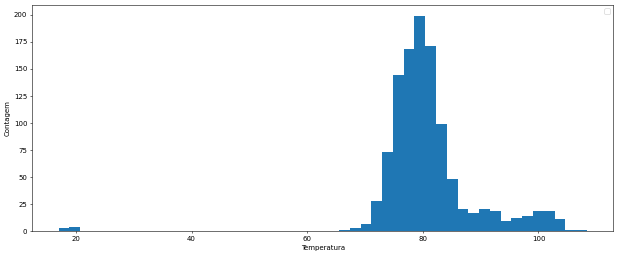

In [ ]:
temperaturas = dataset.to_numpy()
temperaturas = temperaturas[:,3:4]
bins = np.linspace(temperaturas.min(), temperaturas.max(), 50)
plt.figure(figsize=(15, 6), dpi=50)
plt.hist(temperaturas, bins=bins)
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

Text(0.5, 0, 'Temperatura')

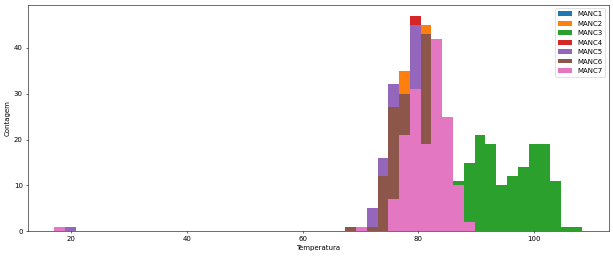

In [ ]:
tempsManc1 = manc1.to_numpy()[:,3:4]
tempsManc2 = manc2.to_numpy()[:,3:4]
tempsManc3 = manc3.to_numpy()[:,3:4]
tempsManc4 = manc4.to_numpy()[:,3:4]
tempsManc5 = manc5.to_numpy()[:,3:4]
tempsManc6 = manc6.to_numpy()[:,3:4]
tempsManc7 = manc7.to_numpy()[:,3:4]

plt.figure(figsize=(15, 6), dpi=50)
plt.hist(tempsManc1, bins=bins, label='MANC1')
plt.hist(tempsManc2, bins=bins, label='MANC2')
plt.hist(tempsManc3, bins=bins, label='MANC3')
plt.hist(tempsManc4, bins=bins, label='MANC4')
plt.hist(tempsManc5, bins=bins, label='MANC5')
plt.hist(tempsManc6, bins=bins, label='MANC6')
plt.hist(tempsManc7, bins=bins, label='MANC7')
plt.legend()
plt.ylabel('Contagem')
plt.xlabel('Temperatura')

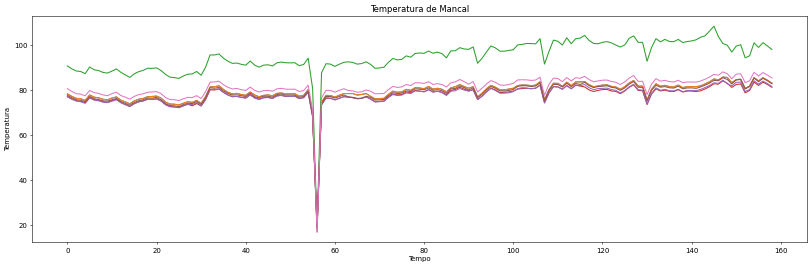

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(tempsManc1)
plt.plot(tempsManc2)
plt.plot(tempsManc3)
plt.plot(tempsManc4)
plt.plot(tempsManc5)
plt.plot(tempsManc6)
plt.plot(tempsManc7)

plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

## Parte 2 - Preprocessamento de Dados

### Separação do conjunto de Treino e Teste

In [ ]:
window     = 4
output_size = 1

In [ ]:
datasetMancal = manc3
#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
#datasetMancal = datasetMancal.astype({"TEMPERATURA": int})
datasetMancal['TEMPERATURA'] = datasetMancal['TEMPERATURA'].round(decimals=1)

#Calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(datasetMancal)*0.7)
test_size  = len(datasetMancal) - train_size

#Separando conjuto de treino e teste apenas com valor da série
train_set = datasetMancal.iloc[0:train_size, 3:4].values
test_set  = datasetMancal.iloc[train_size:(train_size + test_size), 3:4].values

### gráfico da série temporal

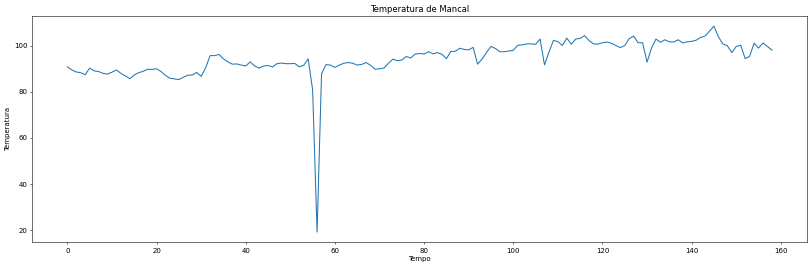

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(datasetMancal.iloc[0:len(datasetMancal), 3:4].values)
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

### Normalização

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [ ]:
def prepareSetRN(windowSize, outputSize, flatSet ):
    preparedX = []
    preparedY = []
    setSize = len(flatSet)
    for i in range(windowSize, setSize - (outputSize-1)):
        preparedX.append(flatSet[i-window:i, 0])
        preparedY.append(flatSet[i:i + output_size, 0])

    preparedX, preparedY = np.array(preparedX), np.array(preparedY)
    return preparedX, preparedY

X_train = []
y_train = []
X_train, y_train = prepareSetRN(window, output_size, training_set_scaled)

### Reshaping

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Parte 3 - Construção da RNN

### Bibliotecas necessárias

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Construção da Rede completa

In [ ]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.25))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = False))
regressor.add(Dropout(0.25))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 80, return_sequences = False))
#regressor.add(Dropout(0.25))

# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.25))

# camada de saída
regressor.add(Dense(units = output_size, activation='linear'))
#Testar sigmoid e linear

# Compilar a rede
regressor.compile(optimizer = 'Nadam', loss = 'mean_squared_error', metrics=['accuracy'])

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 4, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                73920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 165,201
Trainable params: 165,201
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [ ]:
history = regressor.fit(X_train, y_train, epochs = 1200, batch_size = 20)

Epoch 1/1200
6/6 [==============================] - 4s 14ms/step - loss: 0.6341 - accuracy: 0.0093
Epoch 2/1200
6/6 [==============================] - 0s 14ms/step - loss: 0.2358 - accuracy: 0.0185
Epoch 3/1200
6/6 [==============================] - 0s 14ms/step - loss: 0.0190 - accuracy: 0.0093
Epoch 4/1200
6/6 [==============================] - 0s 14ms/step - loss: 0.0159 - accuracy: 0.0093
Epoch 5/1200
6/6 [==============================] - 0s 15ms/step - loss: 0.0159 - accuracy: 0.0093
Epoch 6/1200
6/6 [==============================] - 0s 14ms/step - loss: 0.0155 - accuracy: 0.0093
Epoch 7/1200
6/6 [==============================] - 0s 14ms/step - loss: 0.0166 - accuracy: 0.0093
Epoch 8/1200
6/6 [==============================] - 0s 14ms/step - loss: 0.0156 - accuracy: 0.0093
Epoch 9/1200
6/6 [==============================] - 0s 15ms/step - loss: 0.0145 - accuracy: 0.0093
Epoch 10/1200
6/6 [==============================] - 0s 13ms/step - loss: 0.0161 - accuracy: 0.0093
Epoch 11/

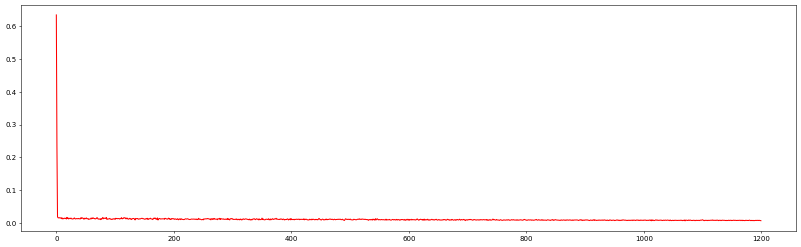

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['loss'], color = 'red', label = 'Loss')

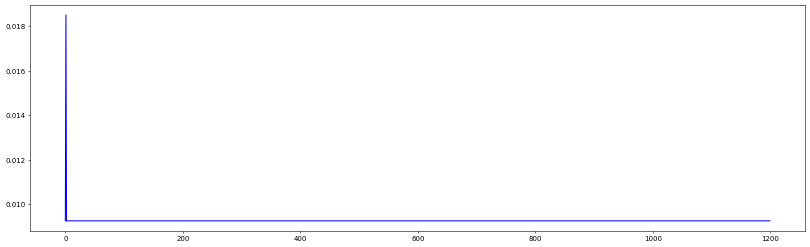

In [ ]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['accuracy'], color = 'blue', label = 'Accuracy')

## Parte 4 - Fazer as previsões e analisar os resultados

### Base de teste

### Construir a estrutura para teste

In [ ]:
#Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
test_set_first_window  = dataset.iloc[train_size - window:(train_size + test_size), 3:4].values

test_set_scaled = sc.transform(test_set_first_window)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output_size, test_set_scaled)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [ ]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    #Adiciona as primeiras colunas do primeiro registro quando a janela > 1
    if window_size > 1:
      for i in range(0, window_size-1):
        flatSet.append(windowSet[0, i])

    for i in range(0, setSize):
        flatSet.append(windowSet[i, window_size-1])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

predicted = regressor.predict(X_train)
predicted = sc.inverse_transform(predicted)

training_predicted = backToFlat(predicted)

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

### Visualizar os resultados de treino e teste

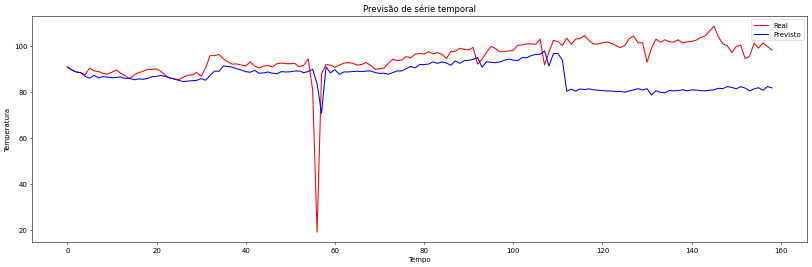

In [ ]:
allTargetData = np.vstack((test_set))
allForecastedData = np.vstack((test_predicted))

allTargetData = np.vstack((train_set, test_set))
allForecastedData = np.vstack((train_set[0:window], training_predicted, test_predicted))

plt.figure(figsize=(20, 6), dpi=50)
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

In [ ]:
for i in range(0, 20):
  print( allTargetData[i], allForecastedData[i])

[90.7] [90.7]
[89.4] [89.4]
[88.5] [88.5]
[88.2] [88.2]
[87.3] [86.58470917]
[90.2] [85.82733917]
[89.] [87.04011536]
[88.7] [85.92791748]
[87.9] [86.50878906]
[87.6] [86.26474762]
[88.4] [85.98168182]
[89.4] [86.14494324]
[87.9] [86.32594299]
[86.8] [85.69293213]
[85.6] [85.72163391]
[87.2] [85.11083984]
[88.2] [85.48034668]
[88.8] [85.34205627]
[89.7] [85.70709991]
[89.6] [86.46540833]


## Parte 5 - Métricas de avaliação

In [ ]:
rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
print('RMSE: ', rmse)

RMSE:  20.604773900097744


In [ ]:
mse = mean_squared_error(test_set, test_predicted)
print('MSE: ',mse)

MSE:  424.5567074741492


In [ ]:
mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100
print('MAPE: ',mape, '%')

MAPE:  20.104958492021105 %
